In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

from scripts_ml.ann_utils import *

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10276629582715254220
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6956390201968007164
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3058180017947273449
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 24199030375
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15093585126457668881
physical_device_desc: "device: 0, name: Quadro P6000, pci bus id: 0000:00:05.0, compute capability: 6.1"
]


In [3]:
#importing data
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
prefix_time_seq = 'time_2018-02-20_p180_bg_'
valid_code = '_val_26000_2000_'
trainfile = '_traindata'
testfile = '_testdata'
postfix_time_seq_val = '_190824_1812'
postfix_time_seq = '_190824_1321'
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
indexfile = '_fold_indexes'
expname = preproc_folder+"_p180"

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+trainfile+postfix_time_seq+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+testfile+postfix_time_seq+'.pkl') 
[val_X_train, val_y_train, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+trainfile+postfix_time_seq_val+'.pkl') 
[val_X_test, val_y_test, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+testfile+postfix_time_seq_val+'.pkl') 
indexes = pd.read_pickle(datafolder+prefix_time_seq+valid_code+indexfile+postfix_time_seq_val+'.pkl')

In [4]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from tensorflow.keras.models import Sequential

In [5]:
t = np.array([1,2,3,4])

In [6]:
val_X_train[indexes[1][0]][-26000:]

array([[ 0.36924228, -0.35570025, -0.06770506, ...,  0.87026465,
         0.6563815 , -1.2938236 ],
       [ 0.36924228, -0.35570025, -0.06770506, ...,  1.0540245 ,
         0.7009324 , -1.2938236 ],
       [ 0.36924228, -0.35570025, -0.06770506, ..., -1.9231428 ,
        -0.0208545 , -1.2938236 ],
       ...,
       [ 0.36326364, -0.34913978, -0.0695048 , ..., -0.41388178,
         0.29603317, -1.7268667 ],
       [ 0.36326364, -0.34913978, -0.0695048 , ..., -0.20744123,
         0.34986416, -1.7268667 ],
       [ 0.36326364, -0.34913978, -0.0695048 , ...,  0.19374357,
         0.45447624, -1.7268667 ]], dtype=float32)

In [47]:
#recombining folds for grid search

val_X_tr = []
val_y_tr = []
val_X_tst = []
val_y_tst = []
indexes_tuples = []

count=0
start_tr=0

for idx in indexes:
    val_X_tr.append(list(val_X_train[idx[0][-26000:]]))
    val_y_tr.append(list(val_y_train[idx[0][-26000:]]))
    if count==0:
        test_idx = np.array(range(0, len(idx[1])))
    else:
        test_idx+=len(idx[1])
    val_X_tst.append(list(val_X_test[test_idx]))
    val_y_tst.append(list(val_y_test[test_idx]))
    
    
    if count==0:
        start_tst = len(idx[0])
    else:
        start_tr+=add_to_tr
        start_tst=start_tr+len(idx[0])
        
    indexes_tuples.append((np.array(range(start_tr, start_tr+len(idx[0]))), 
                          np.array(range(start_tst, start_tst+len(idx[1])))))
    
    add_to_tr = len(idx[0])+len(idx[1])
    
    count+=1

In [48]:
X = np.array(val_X_tr)
X=X.reshape((X.shape[1], X.shape[0], X.shape[2]))
#y = np.array([val_X_all[1]])


In [98]:
y = np.array(val_y_tr)
y = y.reshape((X.shape[0], X.shape[1],1))
y.shape

(26000, 8, 1)

In [99]:
X_val = np.array(val_X_tst)
X_val = X_val.reshape((X_val.shape[1], X_val.shape[0], X_val.shape[2]))

In [100]:
y_val = np.array(val_y_tst)
y_val = y_val.reshape((X_val.shape[0], X_val.shape[1],1))

In [101]:
from sklearn.utils import class_weight

#class_weights = class_weight.compute_class_weight('balanced',
#                                                 np.unique(y_val),
#                                                 y_train)

cw = class_weight.compute_sample_weight({False:1, True:50},#'balanced',
                                                 #np.unique(y_train),
                                                 y_val.flatten())

In [166]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, dropout=0.6, recurrent_dropout=0.6))
#model.add(LSTM(80, return_sequences=True, dropout=0.6, recurrent_dropout=0.6, activation='relu'))
#model.add(LSTM(60, return_sequences=True, dropout=0.2, activation='relu'))
model.add(LSTM(20, return_sequences=True, dropout=0.6, recurrent_dropout=0.6, activation='relu'))
model.add(LSTM(10, return_sequences=True, dropout=0.6))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.AUC()])

/usr/local/lib/python3.5/dist-packages/tensorflow/python/platform/tf_logging.py:161: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  get_logger().warn(msg, *args, **kwargs)


In [167]:
#model.build(X.shape)
#model.summary()
#rmsprop the best so far

In [168]:
y_val.shape

(2000, 8, 1)

In [169]:
with tf.device("/device:GPU:0"):
    model.fit(X, y, epochs=1000, batch_size=1024, verbose=1, validation_data=(X_val, y_val), shuffle=False)

Train on 26000 samples, validate on 2000 samples
Epoch 1/1000
26000/26000 [==============================] - 6s 225us/sample - loss: 0.6871 - acc: 0.6103 - auc_20: 0.4939 - val_loss: 0.6816 - val_acc: 0.8081 - val_auc_20: 0.4165
Epoch 2/1000
26000/26000 [==============================] - 2s 83us/sample - loss: 0.6794 - acc: 0.7064 - auc_20: 0.4924 - val_loss: 0.6740 - val_acc: 0.8566 - val_auc_20: 0.4189
Epoch 3/1000
26000/26000 [==============================] - 2s 85us/sample - loss: 0.6714 - acc: 0.7676 - auc_20: 0.4888 - val_loss: 0.6666 - val_acc: 0.8814 - val_auc_20: 0.4269
Epoch 4/1000
26000/26000 [==============================] - 2s 84us/sample - loss: 0.6639 - acc: 0.8072 - auc_20: 0.4926 - val_loss: 0.6594 - val_acc: 0.8917 - val_auc_20: 0.4245
Epoch 5/1000
26000/26000 [==============================] - 2s 85us/sample - loss: 0.6564 - acc: 0.8347 - auc_20: 0.4940 - val_loss: 0.6524 - val_acc: 0.8986 - val_auc_20: 0.4262
Epoch 6/1000
26000/26000 [=============================

KeyboardInterrupt: 

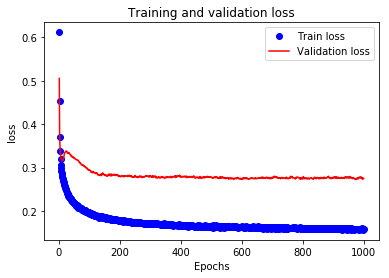

In [159]:
history = model.history.history
plot_epochs_graph(history, 'loss', True)

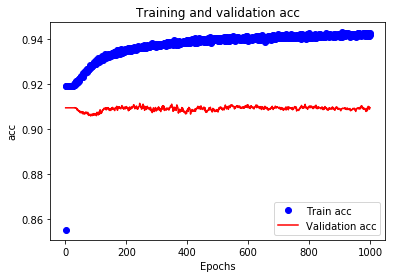

In [160]:
plot_epochs_graph(history, 'acc', True)

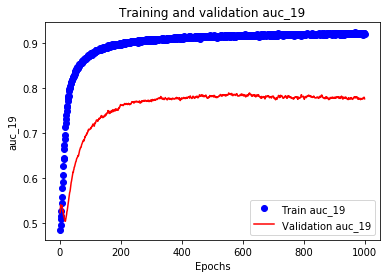

In [161]:
plot_epochs_graph(history, 'auc_19', True)

In [162]:
y_scores = model.predict(X_test.reshape(y_test.shape[0],1,35))

In [163]:
y_scores = y_scores.flatten()

In [164]:
y_test.shape

(15540,)

In [165]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc=roc_auc_score(y_test, y_scores)
print("AUC {:.3f}".format(auc))

AUC 0.815
